# Baseline Model

This notebook guides you through training the baseline model for the BraTS2023 Inpaining Challenge. Feel free to modify and extend the approach to your liking. For more in-depth modifications, also look at ```train_Pix2Pix3D.py``` for the Pix2Pix model. As an additional model, which we do not consider as baseline, we show how to train an Autoencoder (```train_AE.py```).

*Notebook runtime including training:*
 - Training: Roughly 2-3 days when using one GPU. Training the model can be done using a separate file (see training sections) 
 - Other parts of the notebook: roughly 5 minutes.


## Section Overview

- **Imports and Parameters**:  
    Import required python libraries and set script-wide parameters.
    
- **Training Dataset**:  
    Setting up the Dataset and show some examples.
    
- **Monitoring Progress - TensorBoard**:  
    Short instructions how to start TensorBoard
  
- **Training - Pix2Pix**:  
    Training of the Pix2Pix model (autoencoder with GAN) we use as baseline. Also includes how to load an existing model.
    
- **(Optional) Training - Autoencoder**:  
    Training of an AutoEncoder.
    
- **(Optional) Model Comparison**:  
    Compares the performance of the Pix2Pix model with the AutoEncoder. Might be handy if you want to compare your own model against the baseline.


*Note:* For more details on the baseline model see section 2.3 Baseline Model of our challenge [manuscript](https://arxiv.org/abs/2305.08992)

## Imports and Parameters

In [1]:
#Diverse
from pathlib import Path
import numpy as np
from tqdm import tqdm

#Datasets
from dataset3D import Dataset_Training, Dataset_Inference

#Training
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from baseline_utils import plot_3D
import nibabel as nib

#Models
from baseline_utils import get_latest_Checkpoint # to load last checkpoint
from train_Pix2Pix3D import Pix2Pix3D
from train_AE import AutoEncoder

#Processes
import subprocess
import sys

#Path to training dataset
dataset_path = Path("../BraTS2023_Dataset_Local_Synthesis")

#Seed (For the random number generator. Use this seed to retroduce our output)
seed = 2023

#Crop shape (how big is the cuboid the network is trained on)
crop_shape = (128, 128, 96) # most bounding boxes should fit easily into this volume


## Training Dataset

For training we need the input (task) data and the expected output ("ground truth").
Our input data is:
- The **voided t1n** image: Everything we need to infill there is voided
- The **infill mask**: Specifies where the areas are we need to infill with our appraoch. This includes healthy and unhealthy tissue. 
      
As ground truth we use:
- The **original t1n** image: Contains all tissue including the healthy tissue the network infills. Of course, this ground truth data will not be provided at later stages of the challenge.

As a result, we use two different datasets:
- **Dataset_Training**: Contains data for training including the ground truth data. For training, only the healthy mask is used.
- **Dataset_Inference**: Contains only the data of the inpainting task. No ground truth and the mask spans over healthy tissue and tumor tissue.

In [2]:
datasetInf = Dataset_Inference(dataset_path, crop_shape=(240,240,155)) #Full images
datasetTrain = Dataset_Training(dataset_path, crop_shape=(240,240,155)) #Full images

print(f"Dataset size: {len(datasetTrain)}")
print(f"\tImage shape: {datasetTrain[0]['voided_healthy_image'].shape}")
# Shape: Channel x X(Width) x Y(length/Depth) x Z(Height) -> CWDH

print(f"Training Data: {list(datasetTrain[0].keys())}")
print(f"Inference Data: {list(datasetInf[0].keys())}")

Dataset size: 1251
	Image shape: torch.Size([1, 240, 240, 155])
Training Data: ['gt_image', 'voided_healthy_image', 't1n_path', 'healthy_mask', 'healthy_mask_path', 'cropped_bbox', 'max_v', 'name']
Inference Data: ['voided_image', 't1n_voided_path', 'mask', 'cropped_bbox', 'max_v', 'name']


### Example Figure: Full Brain Sample 

Lets create a dataset with complete (full size) brain samples (**240x240x155**) to get an idea how the samples looks like.

However, for training our baseline model, full sized brain samples are **too big**! We use cropped brain samples (see next section).


Ground truth + Healthy mask:


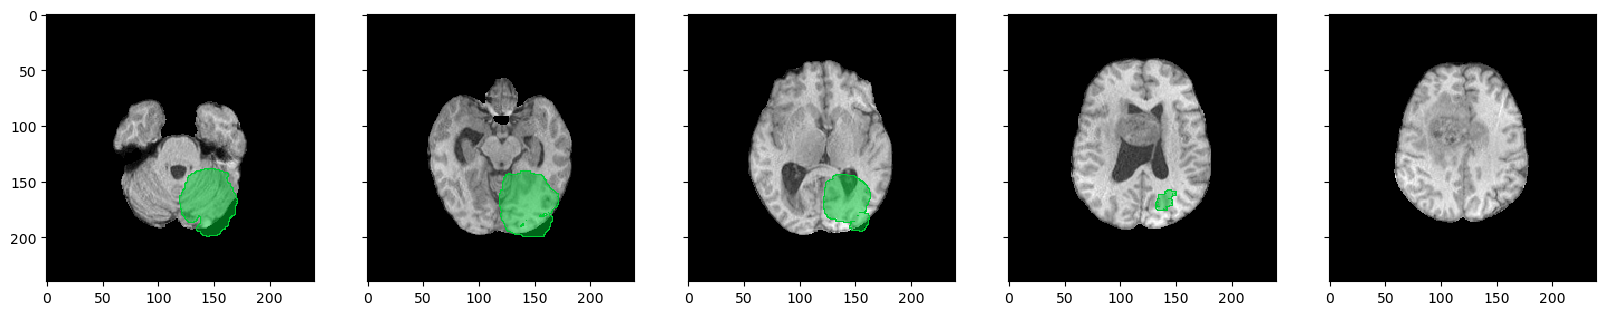

Healthy voided image:


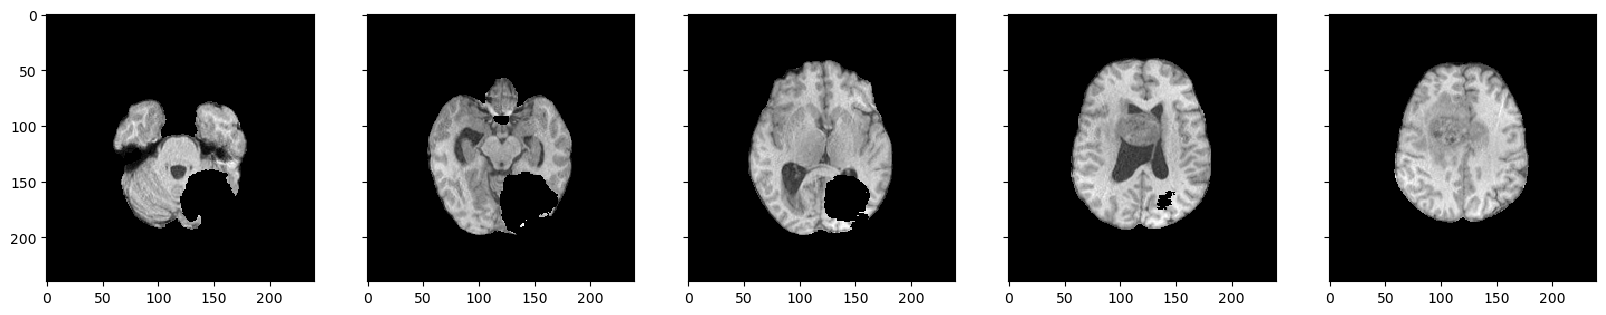

In [3]:
#Get random sample
random_index = np.random.randint(0, len(datasetTrain) - 1)
sample_data = datasetTrain[random_index]

#Plot: ground truth, voided image and the inference mask
print("Ground truth + Healthy mask:")
plot_3D(sample_data["gt_image"], healthyMask=sample_data["healthy_mask"])
print("Healthy voided image:")
plot_3D(sample_data["voided_healthy_image"])


### Example Figure: Cropped Sample

Now we create the cropped version of our brain sample training dataset. It consits of cropped brain samples (**128x128x96**) centered around the infill mask.  


Created dataset with crop shape: (128, 128, 96)
Ground truth + Healthy mask:


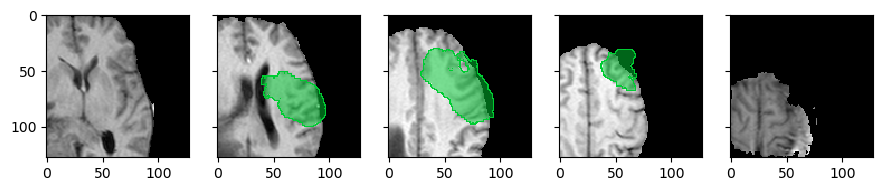

Healthy voided image:


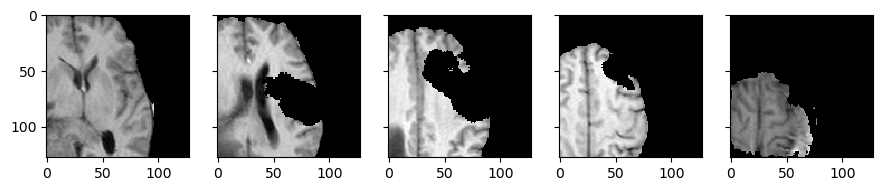

In [4]:
#Create Dataset
datasetTrain_cropped = Dataset_Training(dataset_path, crop_shape=crop_shape, center_on_mask=True)
print(f"Created dataset with crop shape: {crop_shape}")

# plot random sample
random_index = np.random.randint(0, len(datasetTrain_cropped) - 1)
sample_data = datasetTrain_cropped[random_index]

print("Ground truth + Healthy mask:")
plot_3D(sample_data["gt_image"], healthyMask=sample_data["healthy_mask"])
print("Healthy voided image:")
plot_3D(sample_data["voided_healthy_image"])

## Monitoring Progress - TensorBoard

We use TensorBoardLogger for visualization and logging. To start tensorboard, open a seperate command line and navigate to ```baseline/``` where you extracted ```lightning_logs/``` to (this is the baseline model you downloaded from [here](https://syncandshare.lrz.de/dl/fiWmxMzsnrWyY3yAja85JE/lightning_logs.zip).  Then start tensorboard by executing ```tensorboard --logdir lightning_logs/ --port 6006```

Now you can open a web browser and access the website ```http://localhost:6006```

In **scalars** you see the logged **losses** and in **images** you see the images generated by **validation**

The training logs as well as the **checkpoint files** can be found under ```/lightning_logs/{name}/version_*```. Here, ```{name}``` is either "Pix2Pix3D" or "AutoEncoder" (see the following two sections).

**COMPABILITY NOTE:** During testing this repository, we noticed that training does freeze when tensorboard is started before/during training. If you encounter the same issue, try to shutdown tensorboard and only open it when required. Or, alternatively, copy the lightning logs to a different folder where only tensor board is operating on.

In case you find a solution to this issue, please let us know! (e.g. over the Synapse forum or in a GitHub issue)

## Training - Pix2Pix

As training in this notebook might be cumbersome (and not easily transferable to a HPC server), we outsource the training into ```baseline/train_Pix2Pix3D.py```.
In the following, we define the parameters for training and start a subprocess for training with them as arguments.

In case you **struggle** with setting up Pix2Pix, you might want to first to get the **Autoencoder** running (next section). It is less complex, needs less VRAM and training should be faster.

In [5]:
#Define training set
dataset_path = Path("../BraTS2023_Dataset_Local_Synthesis")

#Define training parameters
scriptName = "train_Pix2Pix3D.py"
epochs = 300
batch_size = 2 #~12GB VRAM
gpus = [1,2,3,4]  # list of GPU-Ids
accelerator = "gpu" #if you use CPU, change here to "cpu"
train_p, val_p = 0.8, 0.2 #training, validation split. Needs to sum up to 1

#To resume from check point
modelName = "Pix2Pix3D"
#ckpt_path = get_latest_Checkpoint(modelName, version="*") #uncomment if you want to resume training
ckpt_path = None 

#Build commandline call
commandline = ["python3",scriptName,f"--epochs", str(epochs), "--dataset", str(dataset_path),
               "--batch-size", str(batch_size),  "--accelerator", accelerator]
commandline.append("--gpus")
for gpu in gpus:
    commandline.append(str(gpu))
commandline.extend( ["--seed", str(seed), "--split", str(train_p), str(val_p),
               "--crop-shape", str(crop_shape[0]), str(crop_shape[1]), str(crop_shape[2]),
               "--ckpt-path", str(ckpt_path)] )

print(' '.join(commandline))                                   

python3 train_Pix2Pix3D.py --epochs 300 --dataset ../BraTS2023_Dataset_Local_Synthesis --batch-size 2 --accelerator gpu --gpus 1 2 3 4 --seed 2023 --split 0.8 0.2 --crop-shape 128 128 96 --ckpt-path None


**Uncomment** the next cell to train the model within this notebook. However, live output might not be supported and training can take very long.

Therfore, you might want to **use a seperate command line** and execute the above printed command (```python3 train_Pix2Pix3D.py ...```).

In [6]:
#Start training script
#output = subprocess.Popen(commandline, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#for line in iter(output.stdout.readline, b""): #TODO: make this live output compatible with tqdm updates
#    sys.stdout.write(line)


### Load Model & Infer Results

If you want to load your model you can use the following code. This might be especially useful for testing the model in different scenarios.

#### Using the trained baseline model
If you do not wish to train the baseline model anew, we reommend that you [download the baseline model](https://syncandshare.lrz.de/getlink/fiQJMJPUCUBj1vmvxCdWY4/lightning_logs.zip) we already trained.



Latest checkpoint: lightning_logs/Pix2Pix3D/version_1/checkpoints/epoch=299-step=75600_latest.ckpt
BraTS-GLI-00736-001
Ground truth + mask:


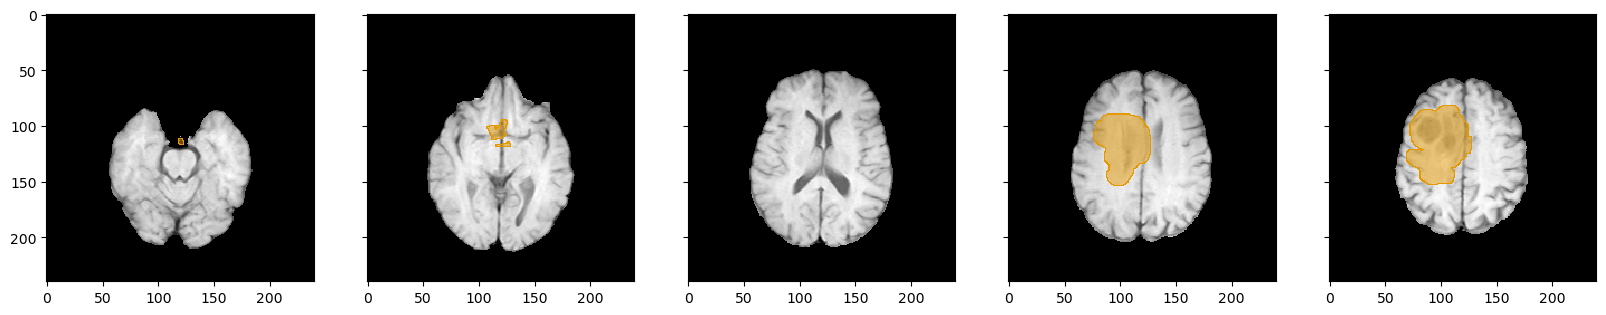

Voided Image:


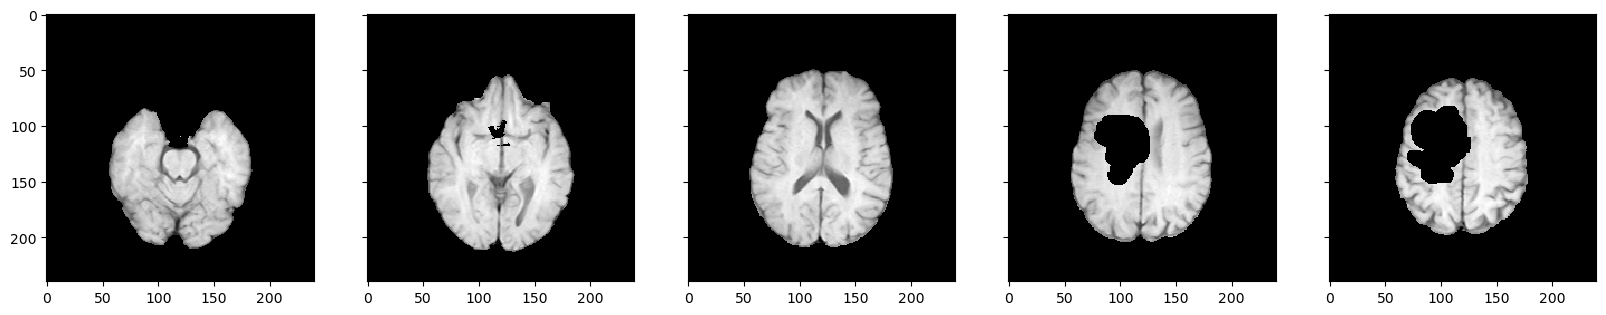

Result:


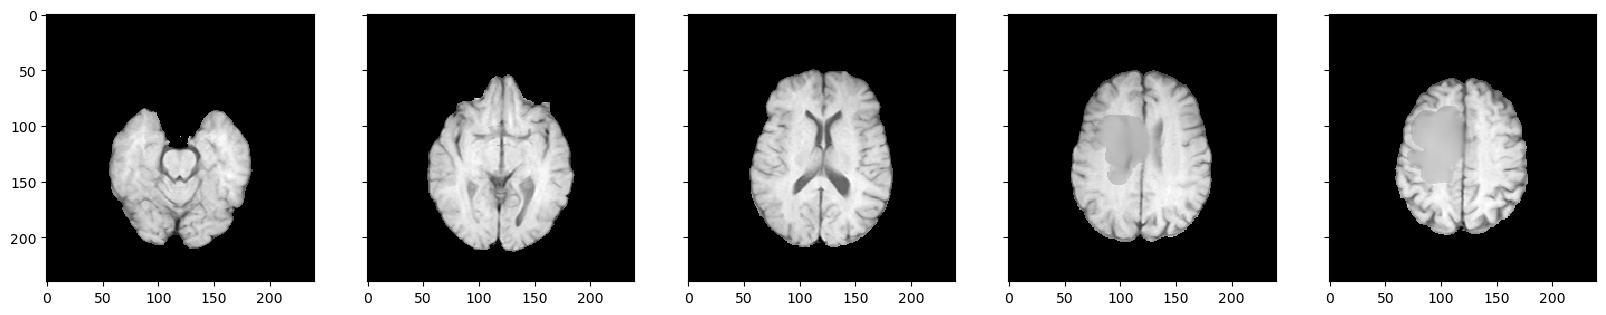

Ground truth:


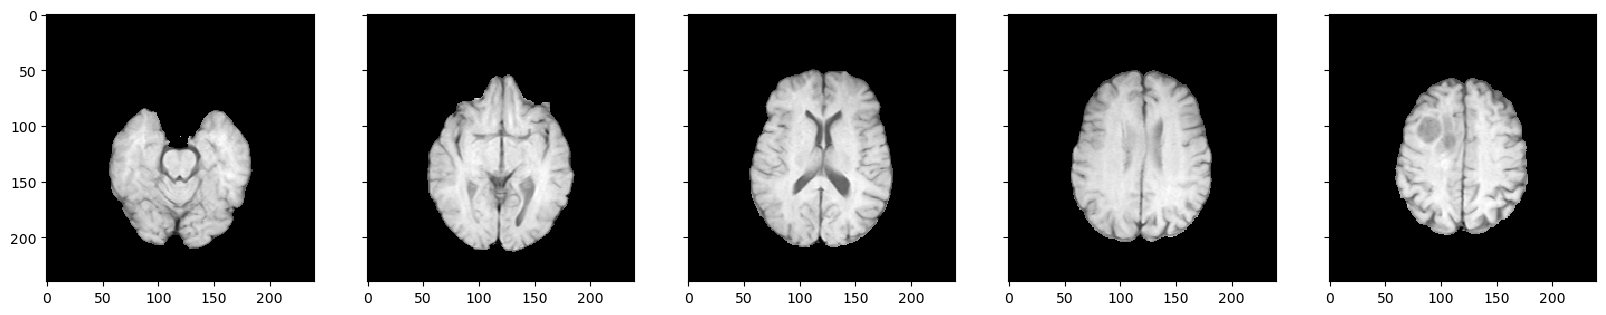

In [7]:
#Setup evaluation dataset 
torch.manual_seed(seed) #same seeding ensure we end up with the same split
eval_dataset = Dataset_Inference(dataset_path, crop_shape=crop_shape, center_on_mask=True)

#Get latest model checkpoint
latest_checkpoint = get_latest_Checkpoint(modelName, version="*")
if(latest_checkpoint == None):
    raise UserWarning("No latest model found!")
else:
    print(f"Latest checkpoint: {latest_checkpoint}")

#Load your model
model = Pix2Pix3D.load_from_checkpoint(latest_checkpoint, map_location=torch.device('cuda')) 
model.eval()  # Make drop-out/Norms and other deterministic
model.cuda()  # Move to GPU

#Choose Sample(s)
sample = eval_dataset[np.random.randint(0, len(eval_dataset) - 1)]
#for sample in tqdm(eval_dataset):
print(sample["name"])

#Inference
voided_image = sample["voided_image"].unsqueeze(0) # add batch (1, 160, 160, 96) -> (1, 1, 160, 160, 96)
mask = sample["mask"].unsqueeze(0)
with torch.no_grad():
    prediction = model.forward(voided_image.cuda(), mask.cuda())
    result, image = eval_dataset.get_result_image(prediction[0].cpu().numpy(), sample) #returns 3D image (X,Y,Z)

#Get ground truth and voided (for comparison)
t1n_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-t1n.nii.gz")
t1n = nib.load(t1n_path).get_fdata()
voided_image_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-t1n-voided.nii.gz")
voided_image = nib.load(voided_image_path).get_fdata()
mask_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-mask.nii.gz")
mask = nib.load(mask_path).get_fdata()

#Show Sample
print("Ground truth + mask:")
plot_3D(t1n, generalMask=mask)
print("Voided Image:")
plot_3D(voided_image)
print("Result:")
plot_3D(result)
print("Ground truth:")
plot_3D(t1n)


**Note:** If the above cell does not find a latest model (*UserWarning: No latest model found!*), you have no existing models in *lighting_logs*. Either [download the pre-trained baseline model](
https://syncandshare.lrz.de/dl/fiWmxMzsnrWyY3yAja85JE/lightning_logs.zip) or train it yourself first.

## (Optional) Training - Autoencoder

As a more simplistic model we also provide code for an Autoencoder (```train_AE.py```). It is smaller (less VRAM) and faster to train but not as good at solving the inpatinting task.

In [8]:
#Define training parameters
scriptName = "train_AE.py"
epochs = 100
crop_shape=(192,192,144)
batch_size = 2
gpus = [1,2,3,4]
dataset_path = Path("../BraTS2023_Dataset_Local_Synthesis")

#To resume from check point
modelName = "AutoEncoder"
#ckpt_path = get_latest_Checkpoint(modelName, version="*") #uncomment if you want to resume training
ckpt_path = None 

#Build commandline call
commandline = ["python3",scriptName,f"--epochs", str(epochs), "--dataset", str(dataset_path),
               "--batch-size", str(batch_size),  "--accelerator", accelerator]
commandline.append("--gpus")
for gpu in gpus:
    commandline.append(str(gpu))
commandline.extend( ["--seed", str(seed), "--split", str(train_p), str(val_p),
               "--crop-shape", str(crop_shape[0]), str(crop_shape[1]), str(crop_shape[2]),
               "--ckpt-path", str(ckpt_path)] )


print(' '.join(commandline))                                  

python3 train_AE.py --epochs 100 --dataset ../BraTS2023_Dataset_Local_Synthesis --batch-size 2 --accelerator gpu --gpus 1 2 3 4 --seed 2023 --split 0.8 0.2 --crop-shape 192 192 144 --ckpt-path None


In [9]:
#Start training script
#output = subprocess.Popen(commandline, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#for line in iter(output.stdout.readline, b""): #TODO: make this live output compatible with tqdm updates
#    sys.stdout.write(line)


### Load & Infer Results
Same code as in the Pix2Pix section but for the AutoEncoder.

Latest checkpoint: lightning_logs/AutoEncoder/version_1_2/checkpoints/epoch=99-step=100100_latest.ckpt
BraTS-GLI-01173-000
Ground truth + mask:


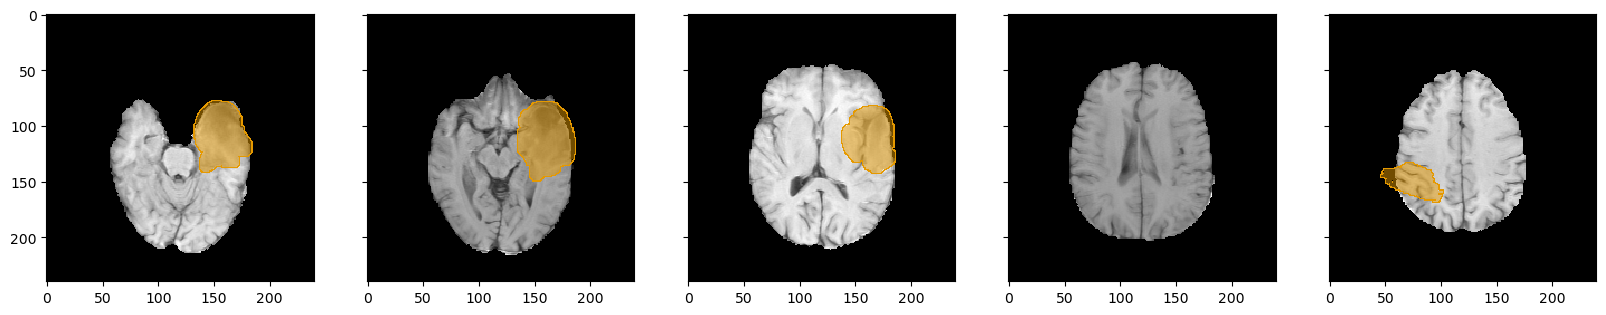

Voided Image:


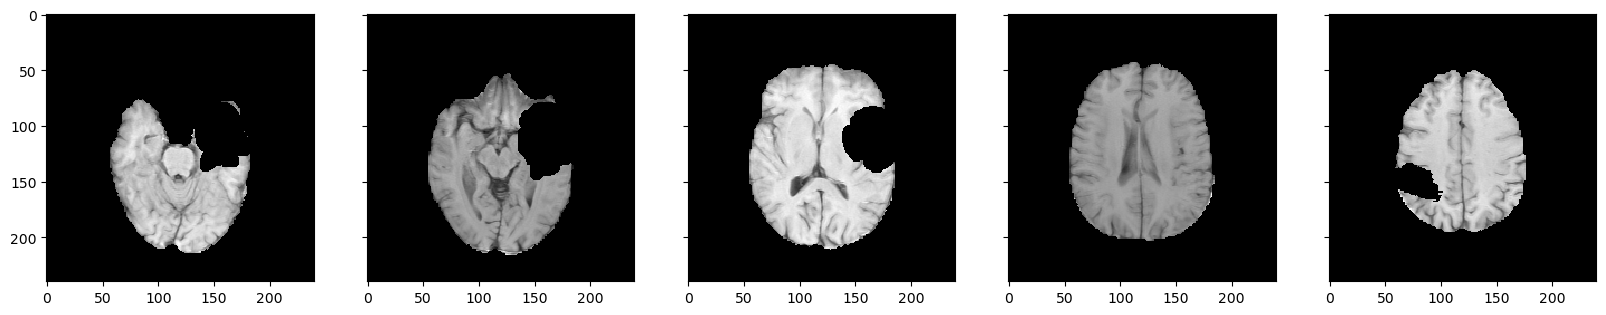

Result:


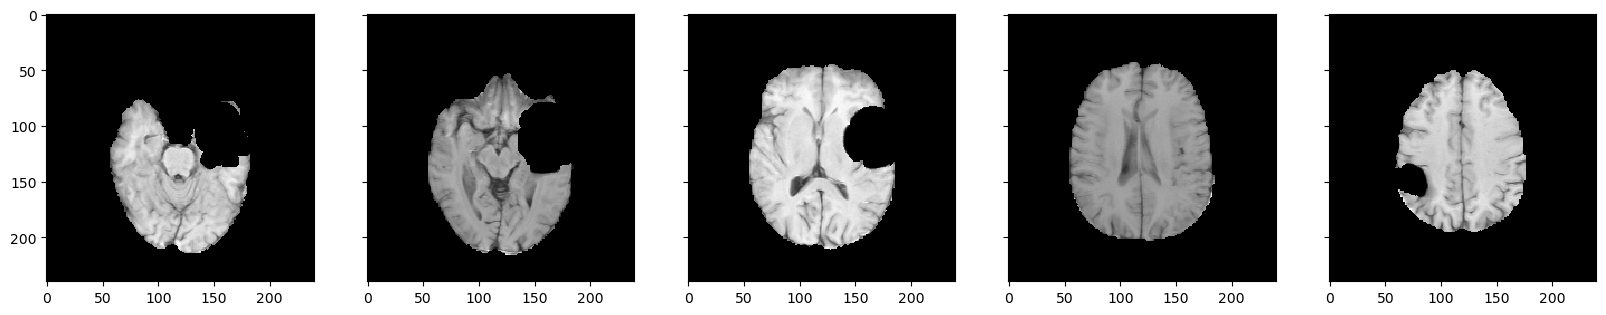

Ground truth:


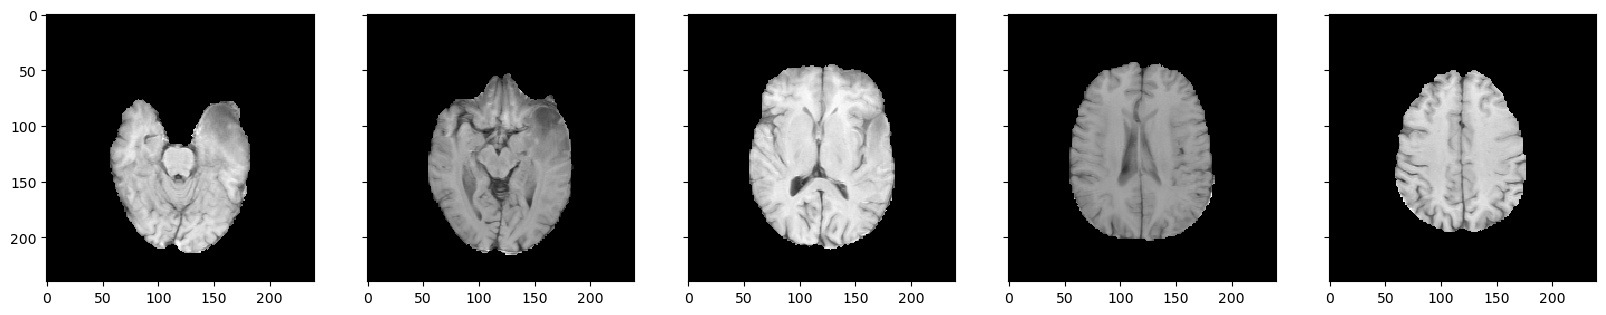

In [10]:
#Get latest model checkpoint
latest_checkpoint = get_latest_Checkpoint(modelName, version="*")
if(latest_checkpoint == None):
    raise UserWarning("No latest model found!")
else:
    print(f"Latest checkpoint: {latest_checkpoint}")

#Load model
model = AutoEncoder.load_from_checkpoint(latest_checkpoint, map_location=torch.device('cuda')) 
model.eval()  # Make drop-out/Norms and other deterministic
model.cuda()  # Move to GPU

#Choose Sample(s) 
sample = eval_dataset[np.random.randint(0, len(eval_dataset) - 1)] #same evel dataset as in Pix2Pix
print(sample["name"])

#Inference
voided_image = sample["voided_image"].unsqueeze(0) # add batch (1, 160, 160, 96) -> (1, 1, 160, 160, 96)
mask = sample["mask"].unsqueeze(0)
with torch.no_grad():
    prediction = model.forward(voided_image.cuda(), mask.cuda())
    prediction = prediction.cpu().numpy()[0] #remove batch
    result, image = eval_dataset.get_result_image(prediction, sample) #returns 3D image (X,Y,Z)

#Get ground truth and voided (for comparison)
t1n_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-t1n.nii.gz")
t1n = nib.load(t1n_path).get_fdata()
voided_image_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-t1n-voided.nii.gz")
voided_image = nib.load(voided_image_path).get_fdata()
mask_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-mask.nii.gz")
mask = nib.load(mask_path).get_fdata()

#Show Sample
print("Ground truth + mask:")
plot_3D(t1n, generalMask=mask)
print("Voided Image:")
plot_3D(voided_image)
print("Result:")
plot_3D(result)
print("Ground truth:")
plot_3D(t1n)



# (Optional) Model Compairison

Let's compare the performance of the trained AutoEncoder against the Pix2Pix model.

We use the following metrics to quantify how realistic the synthesized image regions are compared to real ones: 
- structural similarity index measure (SSIM),
- peak-signal-to-noise-ratio (PSNR), 
- mean-square-error (MSE).

The ```evaluation/``` sub-repository as well as the [manuscript](https://arxiv.org/pdf/2305.08992.pdf) illustrate evaluation procedures in more detail.

In [11]:
#Make other sub-repositories available
import sys
from pathlib import Path
repoRoot = Path(".").absolute().parent 
sys.path.append(str(repoRoot))

#Get metrics from submission folder
from evaluation.evaluation_utils import compute_metrics

In [12]:

#Models
model_names = ["Pix2Pix3D","AutoEncoder"]
model_classes = [Pix2Pix3D,AutoEncoder] #type:ignore

#Dataset
crop_shape=(128, 128, 96) # increase to do a more accurate performance evaluation!
#crop_shape=(208, 208, 144) #should include (nearly) the whole brain is all cases

torch.manual_seed(seed) #same seeding ensure we end up with the same split
comparison_dataset = Dataset_Training(dataset_path, crop_shape=crop_shape, center_on_mask=True)
train_set, validation_set = torch.utils.data.random_split(comparison_dataset, [train_p, val_p])
comparison_dataset = validation_set # we just use the validation set the model was trained on

#Evaluate both models after each other
performance = {} 
for model_class, model_name in zip(model_classes,model_names):
    
    #Load latest model checkpoint
    latest_checkpoint = get_latest_Checkpoint(model_name, version="*")
    if latest_checkpoint is None:
        print("Did not found checkpoint for", model_name)
        continue
    else:
        print(f"Use checkpoint at: {latest_checkpoint}")
        
    model = model_class.load_from_checkpoint(latest_checkpoint, map_location=torch.device('cuda'))
    model.eval()  # Make drop-out/Norms and other deterministic
    model.cuda()  # Move to GPU
    #model.cpu()  # Move to CPU (if your GPU is too small). Takes much longer (e.g. 1.5h on 16 cores)

    #Setup output structure
    performance[model_name]={
        'PSNR': [],
        'MSE': [],
        'SSIM': []}

    #Compute metrics for each sample in the dataset loop
    print(f"Evaluating {model_name}:")
    itter = tqdm(enumerate(comparison_dataset,start=1),unit=" samples",total=len(comparison_dataset),nrows=3) #type:ignore

    with torch.no_grad():
        for i,sample in itter:
            #Get model input data and add batch dimension
            gt_image = sample["gt_image"].unsqueeze(0)
            voided_image = sample["voided_healthy_image"].unsqueeze(0)
            mask = sample["healthy_mask"].unsqueeze(0)

            #Infere voided regions
            output = model.forward(voided_image.to(model.device), mask.to(model.device)).cpu()
            
            #Compute metrics
            MSE, PSNR, SSIM = compute_metrics(
                output,gt_image,mask,
                normalize=False #when operating on actual MR images you migth want change this
                )
            
            #Add to dictionary
            performance[model_name]['SSIM'].append(SSIM)
            performance[model_name]['PSNR'].append(PSNR)
            performance[model_name]['MSE' ].append(MSE)

            #Print preliminairy mean
            itter.desc = f"SSIM {sum(performance[model_name]['SSIM'])/i:.5f}, PSNR {sum(performance[model_name]['PSNR'])/i:3.3f}, MSE {sum(performance[model_name]['MSE'])/i:.8f}"


Use checkpoint at: lightning_logs/Pix2Pix3D/version_1/checkpoints/epoch=299-step=75600_latest.ckpt
Evaluating Pix2Pix3D:


SSIM 0.67804, PSNR 20.120, MSE 0.01392196: 100%|██████████| 250/250 [04:27<00:00,  1.07s/ samples]


Use checkpoint at: lightning_logs/AutoEncoder/version_1_2/checkpoints/epoch=99-step=100100_latest.ckpt
Evaluating AutoEncoder:


SSIM 0.56305, PSNR 16.998, MSE 0.04274637: 100%|██████████| 250/250 [04:23<00:00,  1.05s/ samples]


**Note**: Jupyter notebooks potentially don't free their GPU storage. You should restart the notebook to free your gpu.